In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# import warnings
# warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
DATA_PATH = Path('/mnt/z/dane/fin-ta/')
INTERVAL = '1d'

In [3]:
def read_ohlc_with_ta_and_trend(symbol):
    full_data_path = DATA_PATH / INTERVAL
    ohlc_df = pd.read_parquet(full_data_path / f'{symbol}.parquet')
    ta_df = pd.read_parquet(full_data_path / f'{symbol}-ta2.parquet')
    trend_df = pd.read_parquet(full_data_path / f'{symbol}-trends2.parquet')
    return ohlc_df.join(ta_df).join(trend_df)

In [4]:
# read all available symbols
symbols = [f.stem[:-3] for f in (DATA_PATH / INTERVAL).glob('*-ta.parquet')]
ticker_dfs = {}
for symbol in symbols:
    ticker_dfs[symbol] = read_ohlc_with_ta_and_trend(symbol)

In [29]:
ticker_dfs['AAPL'].head()

AAPL                                                     HS  \
                Open      High       Low     Close     Volume left_shoulder   
Date                                                                          
1980-12-12  0.098834  0.099264  0.098834  0.098834  469033600             0   
1980-12-15  0.094108  0.094108  0.093678  0.093678  175884800             0   
1980-12-16  0.087232  0.087232  0.086802  0.086802  105728000             0   
1980-12-17  0.088951  0.089381  0.088951  0.088951   86441600             0   
1980-12-18  0.091530  0.091959  0.091530  0.091530   73449600             0   

                                                     ...       IHS       \
           left_neck head right_neck right_shoulder  ... left_neck head   
Date                                                 ...                  
1980-12-12         0    0          0              0  ...         0    0   
1980-12-15         0    0          0              0  ...         0    0   
1980-12-16         0    0          0              0  ...         0    0   
1980-12-17         0    0          0              0  ...         0    0   
1980-12-18         0    0          0              0  ...         0    0   

                                     UPTREND     DOWNTREND     SIDEWAYS      
           right_neck right_shoulder   start end     start end    start end  
Date                                                                         
1980-12-12          0              0       0   0         0   0        0   0  
1980-12-15          0              0       0   0         0   0        0   0  
1980-12-16          0              0       0   0         0   0        0   0  
1980-12-17          0              0       0   0         0   0        0   0  
1980-12-18          0              0       0   0         0   0        0   0  

[5 rows x 21 columns]

In [7]:
def formation_beg_idxs(df, formation):
    return np.nonzero((df[formation].iloc[:, [0]] != 0).any(axis=1))[0]

def formation_end_idxs(df, formation):
    return np.nonzero((df[formation].iloc[:, [-1]] != 0).any(axis=1))[0]

def get_slice_ending_with(series, end_idx, length):
    return series.iloc[max(0, end_idx - length + 1):end_idx + 1].copy()

In [9]:
def max_formation_span(df):
    max_span = 0
    for formation in ['HS', 'IHS']:
        beg_idxs = formation_beg_idxs(df, formation)
        if len(beg_idxs) == 0:
            continue
        end_idxs = formation_end_idxs(df, formation)
        max_span = max(max_span, (end_idxs - beg_idxs).max())
    return max_span

max_span = 0
for ticker in symbols:
    max_span = max(max_span, max_formation_span(ticker_dfs[ticker]))
print(max_span)

45


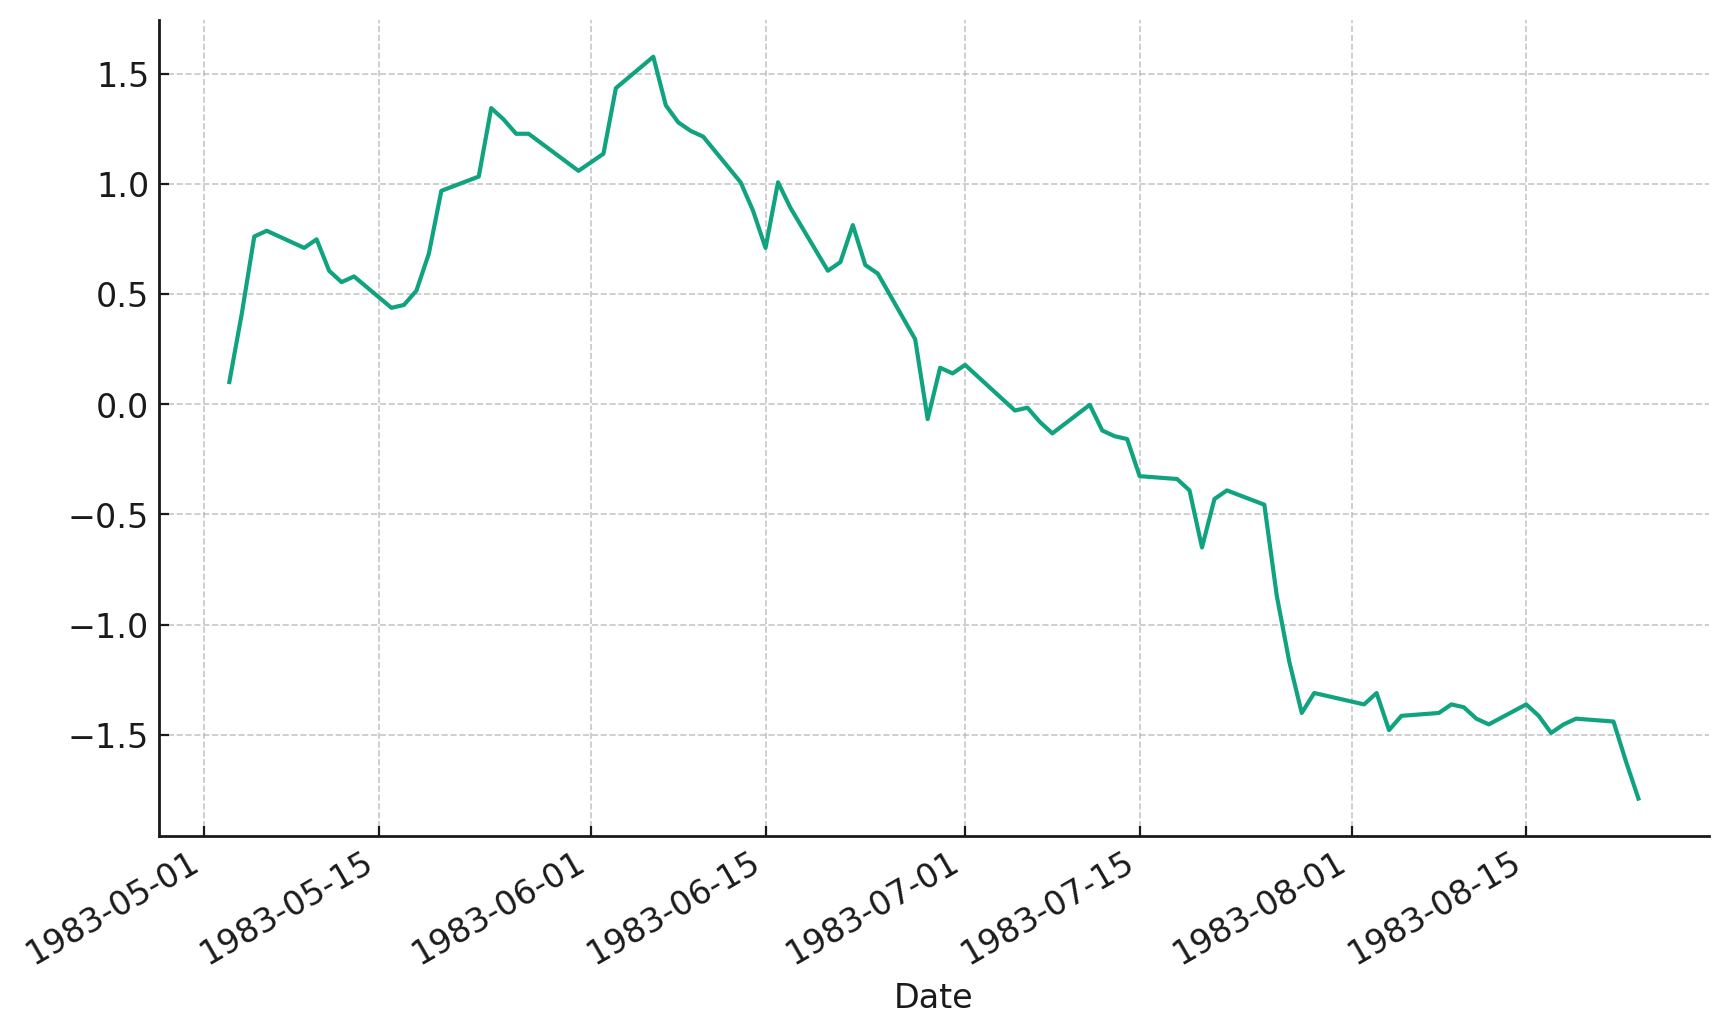

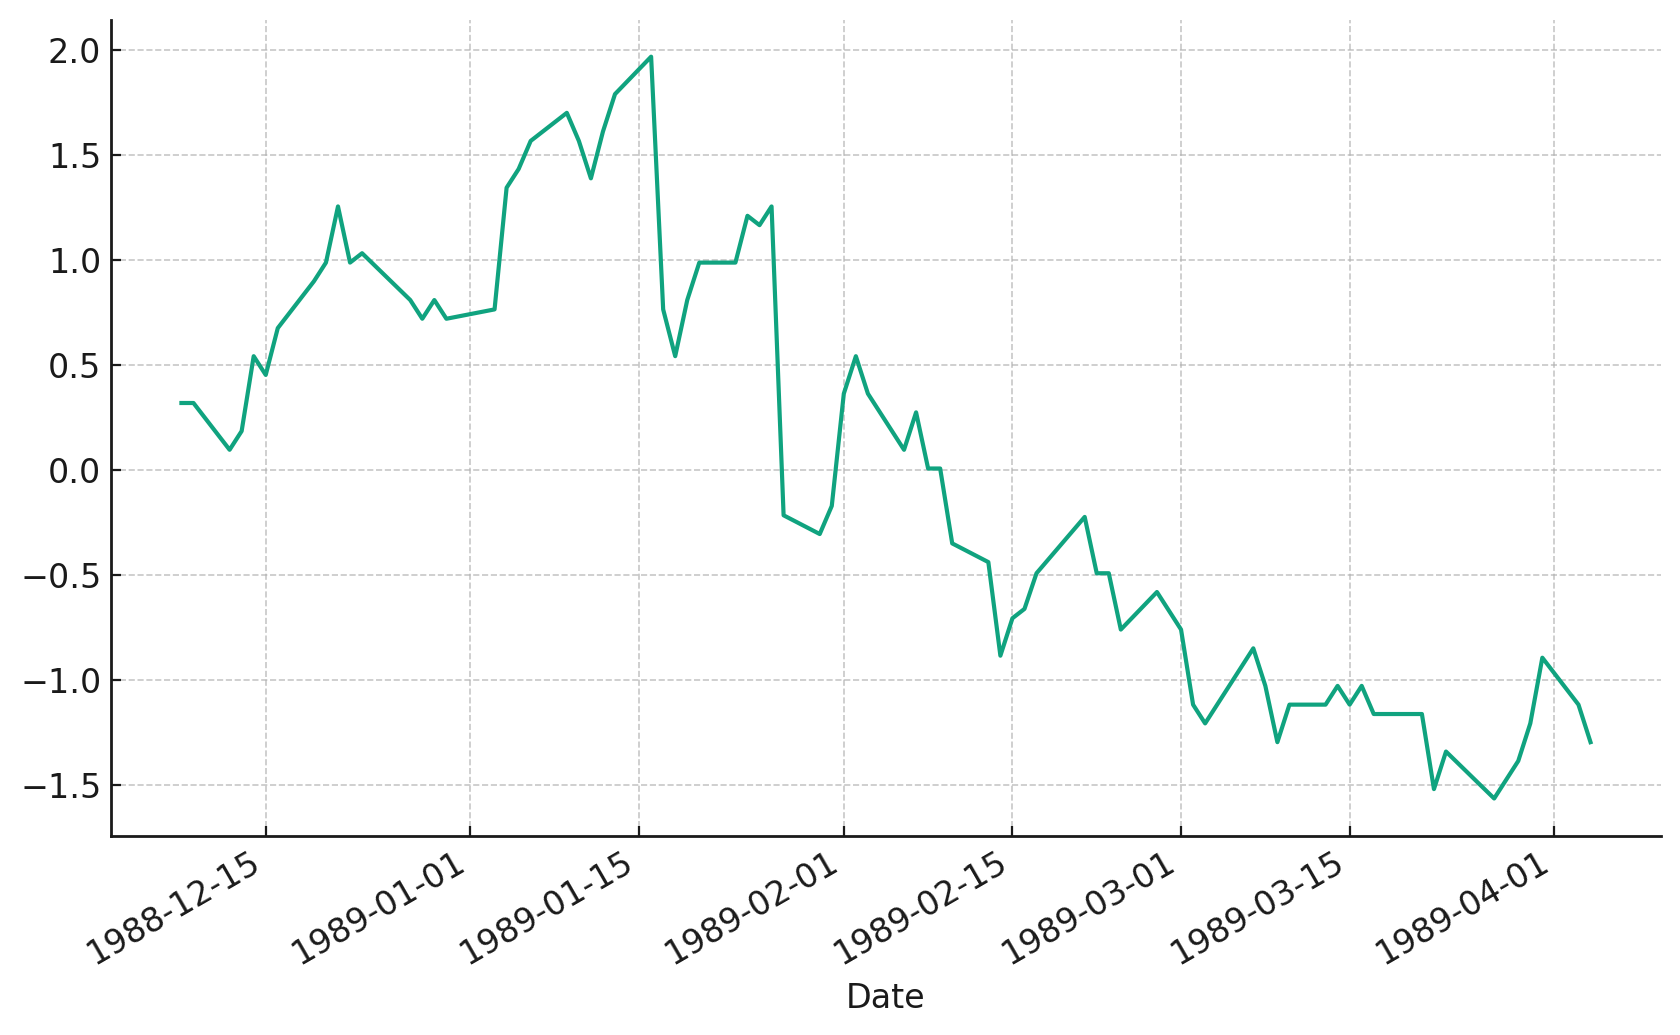

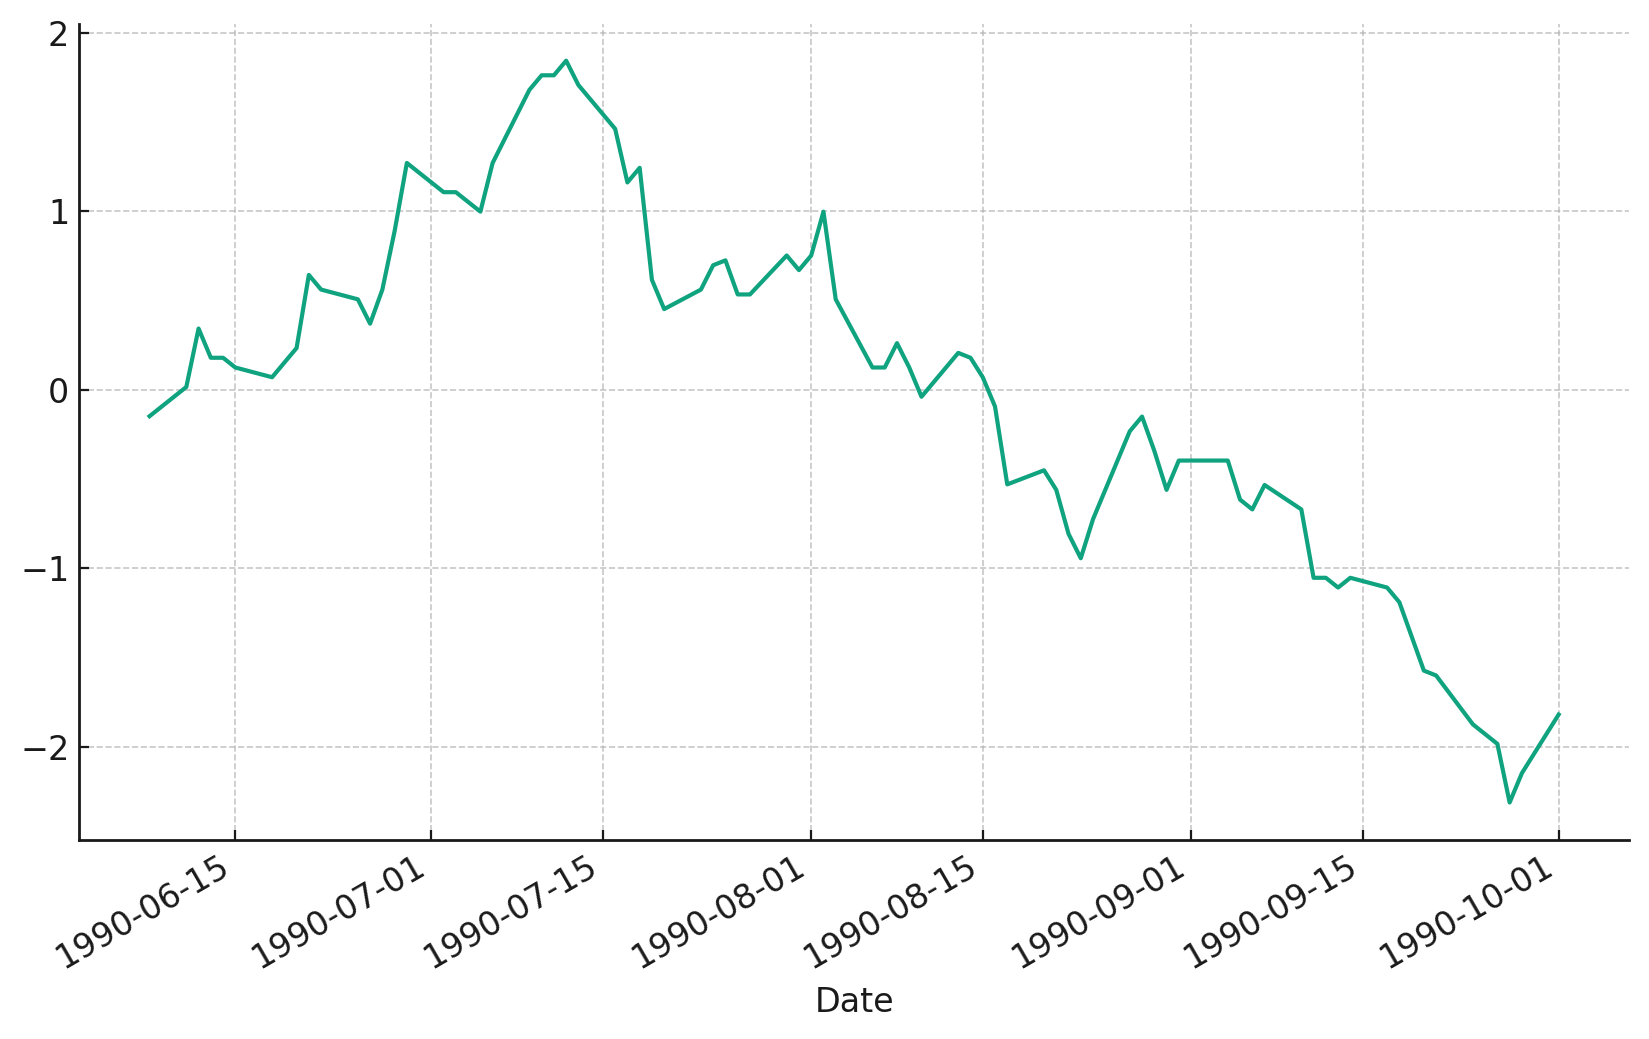

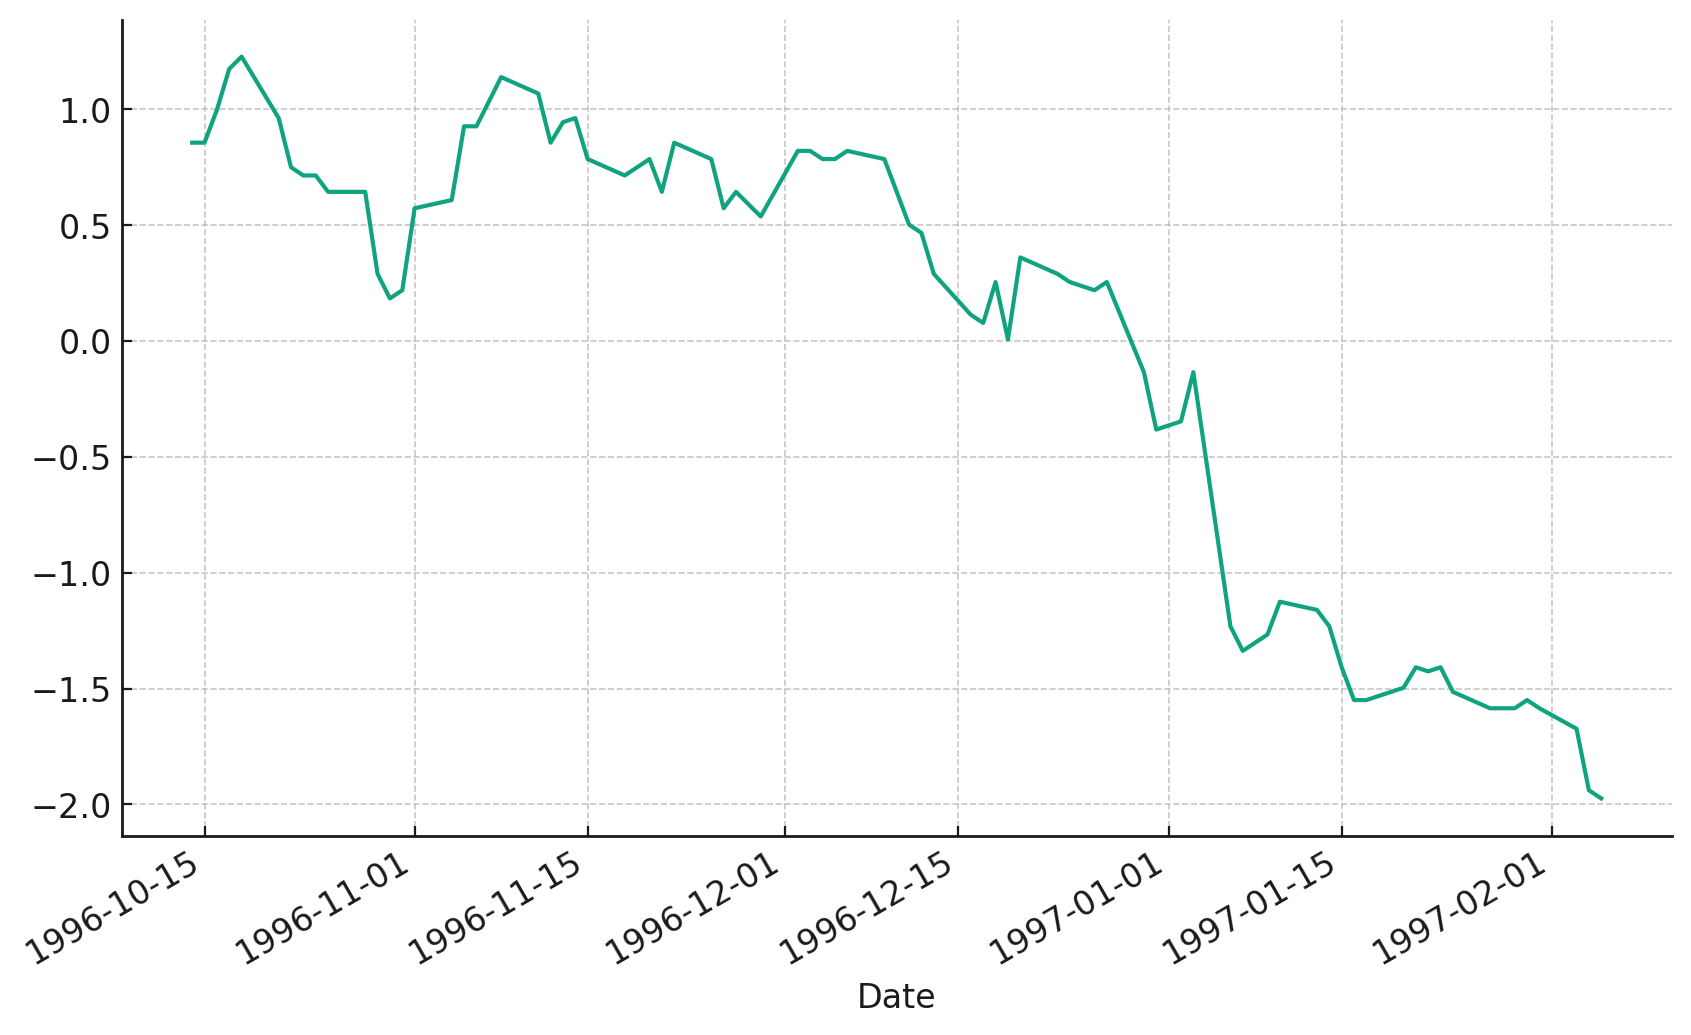

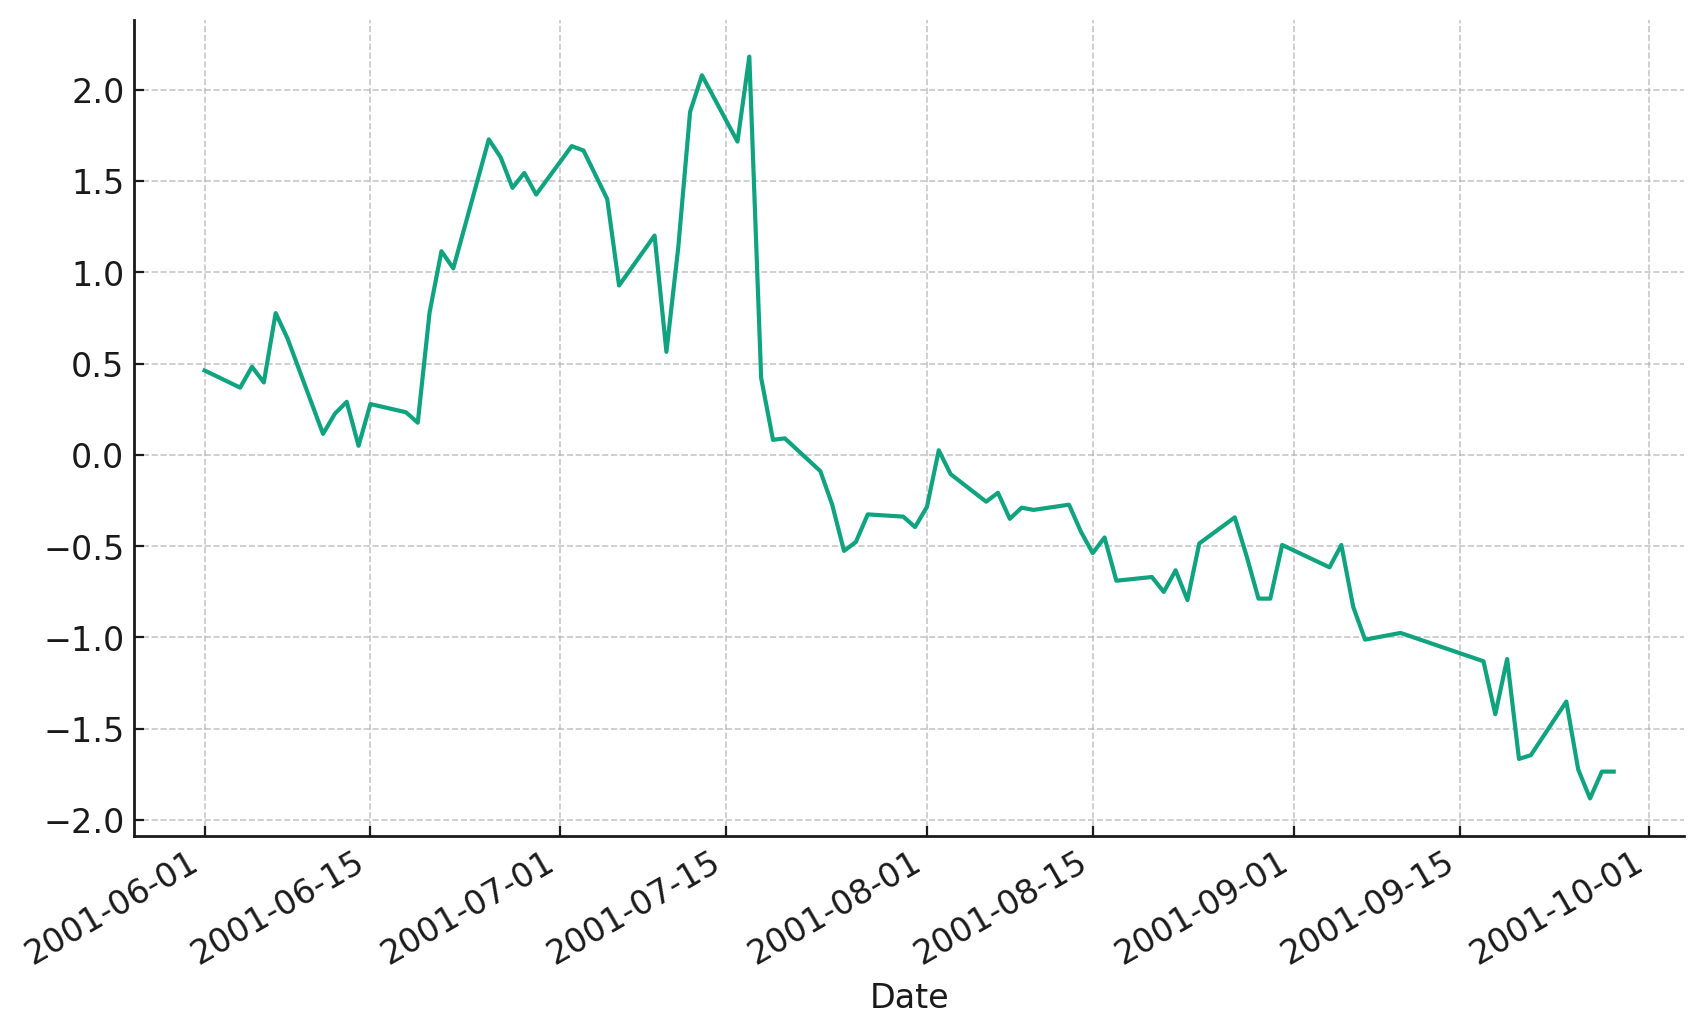

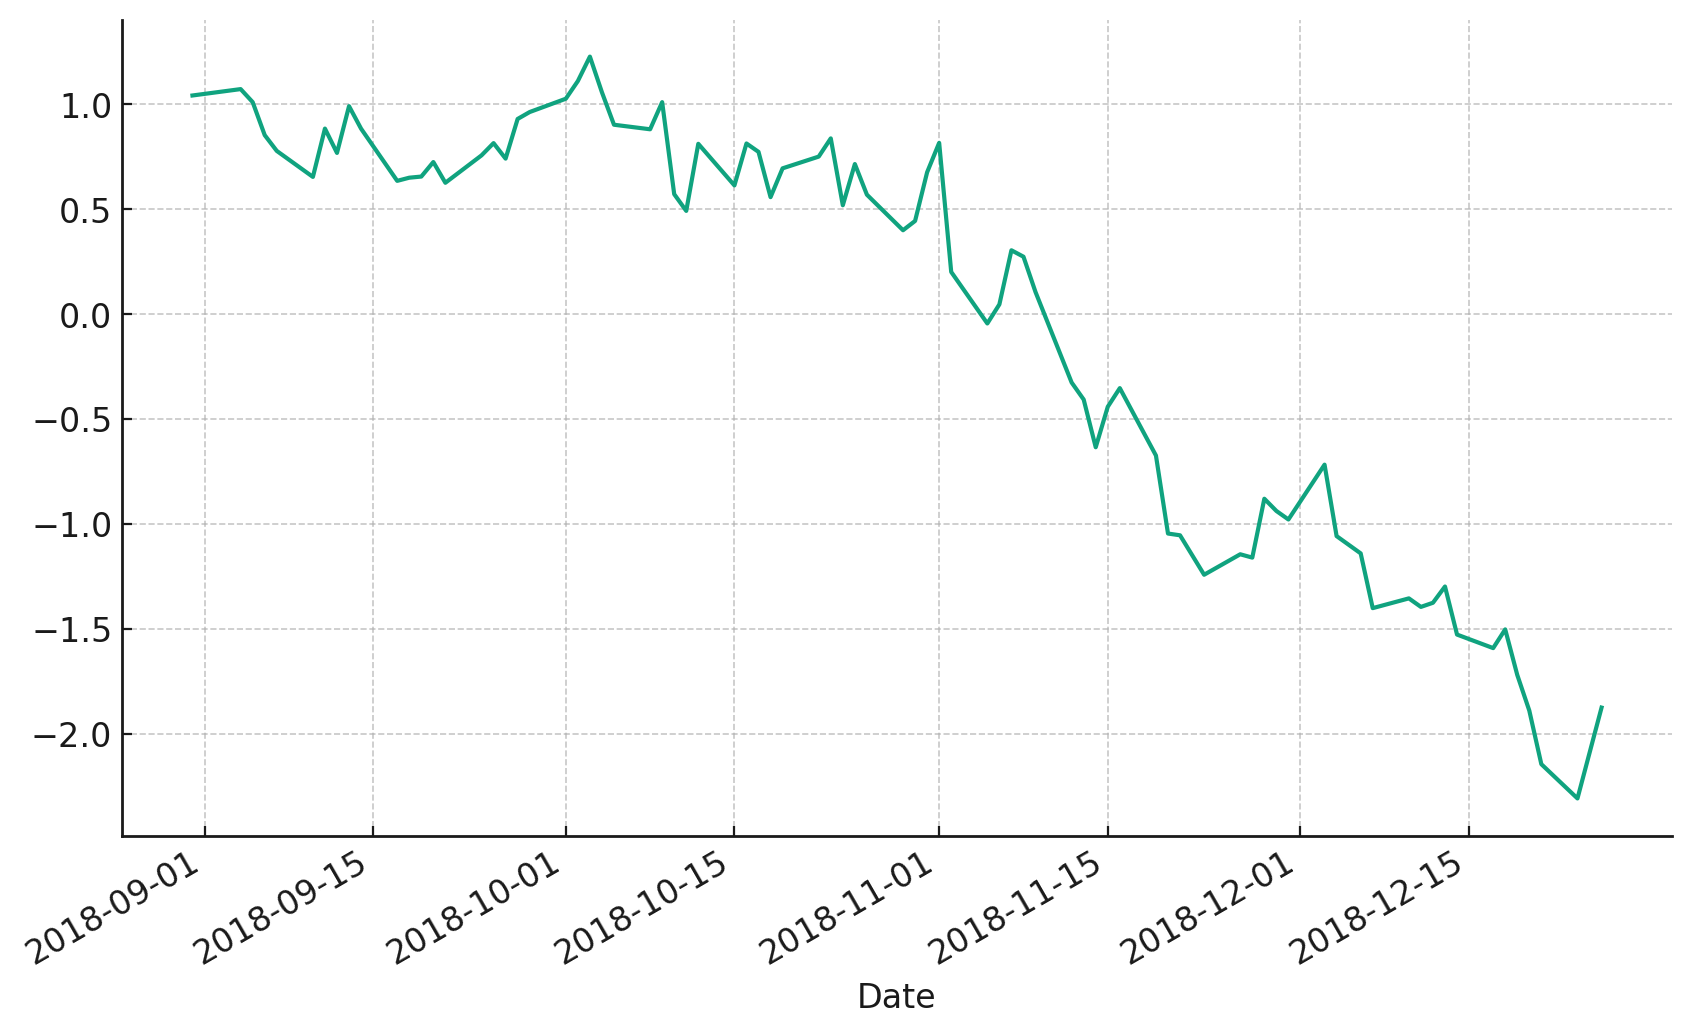

In [30]:
instr = 'AAPL'
df = ticker_dfs[instr]
idxs = formation_end_idxs(df, 'DOWNTREND')
for idx in idxs[:10]:
    X = get_slice_ending_with(df[(instr, 'Close')], idx+7, 80)
    X -= X.mean()
    X /= X.std()
    X.plot()
    plt.show()

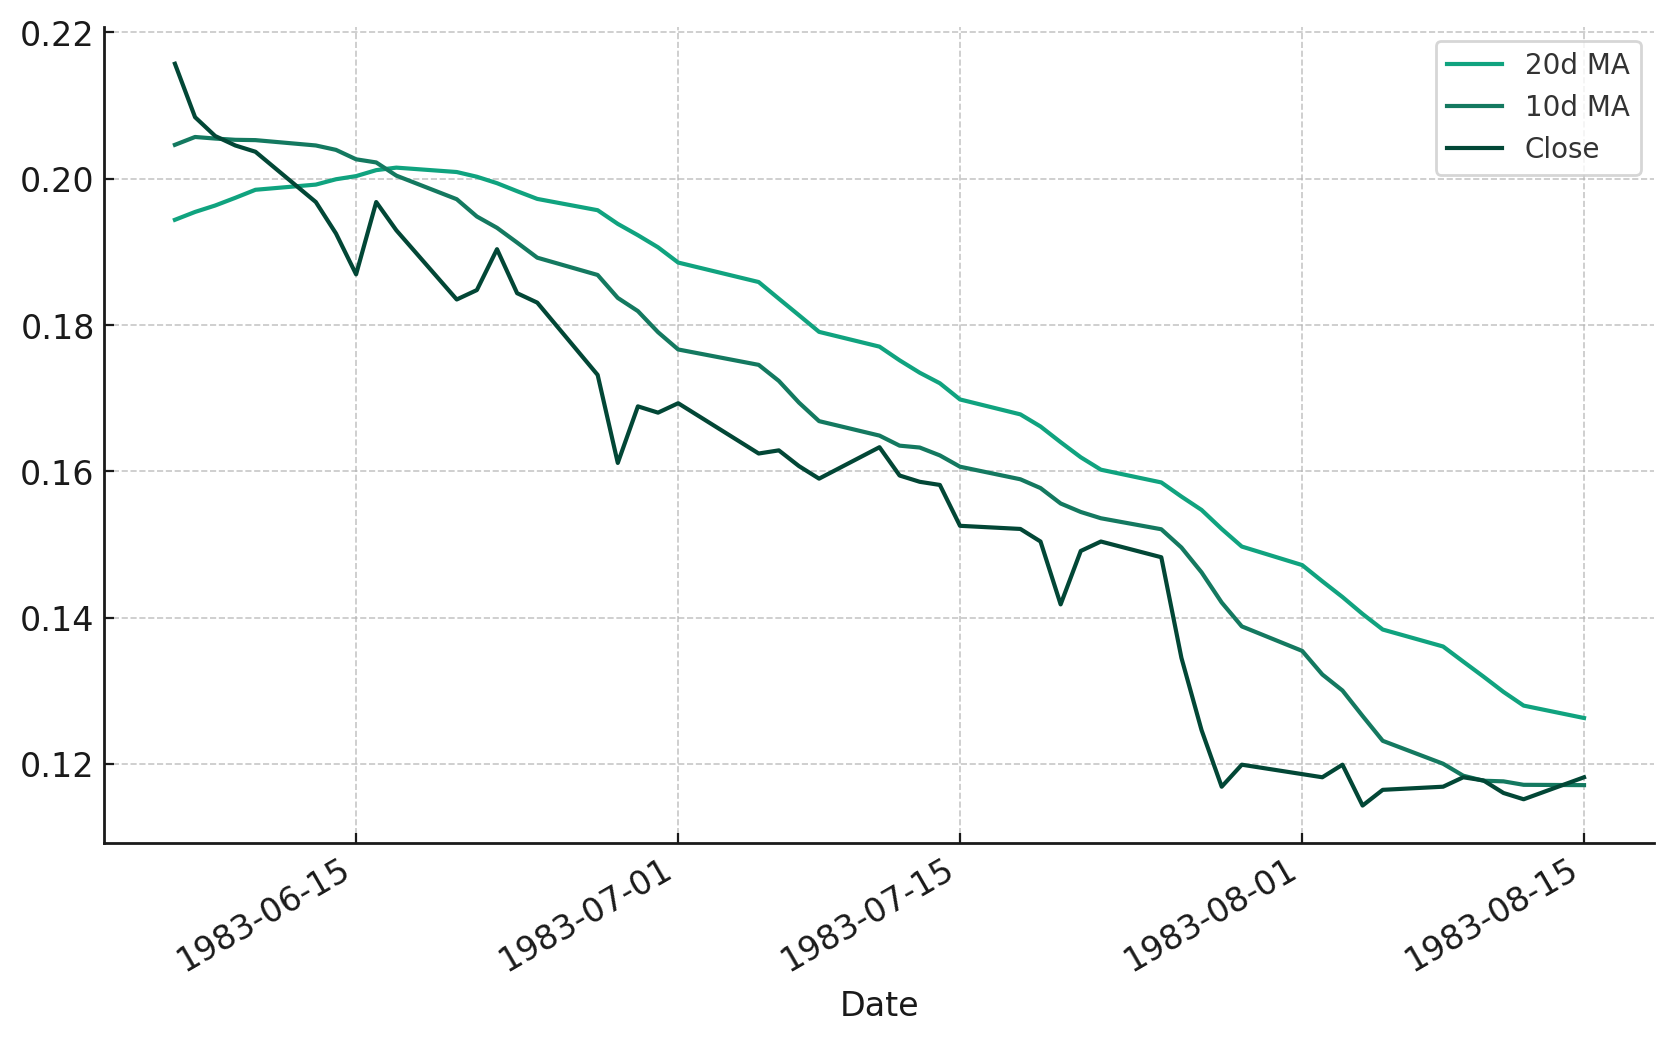

In [36]:
instr = 'AAPL'
df = ticker_dfs[instr]
idxs = formation_end_idxs(df, 'DOWNTREND')
for idx in idxs[:1]:
    s = get_slice_ending_with(df[(instr, 'Close')], idx, 70)
    s.rolling(20).mean()[20:].plot()
    s.rolling(10).mean()[20:].plot()
    s[20:].plot()
    plt.legend(['20d MA', '10d MA', 'Close'])
    plt.show()

In [21]:
idxs = formation_end_idxs(df, 'DT')
idxs = np.concatenate([idxs, formation_end_idxs(df, 'HS')])
idxs.sort()
idxs

array([ 7304,  7341,  7411,  8257,  8569,  8911,  9197,  9391,  9875,
       10049, 10382, 10415, 10459, 10514, 10992, 11107])

In [49]:
c0 = []
for instr in symbols:
    df = ticker_dfs[instr]
    idxs = formation_end_idxs(df, 'UPTREND')
    for idx in idxs:
        slice = get_slice_ending_with(df[(instr, 'Close')], idx, 50).copy()
        if slice.shape[0] < 50:
            continue
        c0.append(slice)
Xs_0 = np.stack(c0)

print(Xs_0[:1])
Xs_0 -= Xs_0.mean(axis=1)[:, np.newaxis]
Xs_0 /= Xs_0.std(axis=1)[:, np.newaxis]
print(Xs_0[:1])

# c1 = []
# for instr in symbols:
#     df = ticker_dfs[instr]
#     idxs = formation_end_idxs(df, 'HS')
#     for idx in idxs:
#         slice = get_slice_ending_with(df[(instr, 'Close')], idx+2, 50)
#         if slice.shape[0] < 50:
#             continue
#         c1.append(slice)
# Xs_1 = np.stack(c1)

# # sample equal number of samples from each class
# smaller_class = min(Xs_0.shape[0], Xs_1.shape[0])
# Xs_0 = Xs_0[:smaller_class]
# Xs_1 = Xs_1[:smaller_class]

# Xs = np.concatenate([Xs_0, Xs_1])
# ys = np.concatenate([np.zeros(Xs_0.shape[0]), np.ones(Xs_1.shape[0])])

# # permute data
# perm = np.random.permutation(Xs.shape[0])
# Xs = Xs[perm]
# ys = ys[perm]


[[0.11645326 0.11387439 0.10828836 0.10055326 0.09840475 0.0975454
  0.09711574 0.09883448 0.10356183 0.10313217 0.10399151 0.10699935
  0.11000718 0.11258528 0.11172592 0.1078587  0.10313217 0.10270242
  0.09797508 0.10356183 0.10399151 0.10012355 0.09453759 0.09883448
  0.10012355 0.10571025 0.10571025 0.11344467 0.11731264 0.11473443
  0.1155939  0.12848529 0.12848529 0.12117983 0.12590638 0.13106337
  0.14008762 0.140947   0.14051732 0.14352512 0.14739235 0.15340875
  0.15126029 0.14524396 0.14395478 0.14524396 0.15469784 0.15985404
  0.15899463 0.15598688]]
[[-0.16094676 -0.28905857 -0.5665589  -0.9508192  -1.05755177 -1.10024214
  -1.12158658 -1.03620363 -0.80136072 -0.82270554 -0.78001554 -0.63059371
  -0.48117188 -0.35309856 -0.3957893  -0.58790297 -0.82270554 -0.84405442
  -1.07889658 -0.80136072 -0.78001554 -0.97216623 -1.24966249 -1.03620363
  -0.97216623 -0.69463259 -0.69463259 -0.31040598 -0.11825492 -0.24633416
  -0.20363787  0.43677461  0.43677461  0.07385765  0.30866058